In [2]:
import pandas as pd 
from googleapiclient.discovery import build

In [40]:
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

In [3]:
API_KEY = 'Your API Key'

In [4]:
def get_trending_videos(api_key, max_results=200):
    # build the youtube service
    youtube = build('youtube', 'v3', developerKey=api_key)

    # initialize the list of video details
    videos = []

    # fetch the most popular videos
    request = youtube.videos().list(
        part = 'snippet,contentDetails,statistics',
        chart = 'mostPopular',
        regionCode = 'US',
        maxResults = 50
    )

    # paginate through the results if max_results > 50
    while request and len(videos) < max_results:
        response = request.execute()
        for item in response['items']:
            video_details = {
                'video_id': item['id'],
                'title': item['snippet']['title'],
                'description': item['snippet']['description'],
                'published_at': item['snippet']['publishedAt'],
                'channel_id': item['snippet']['channelId'],
                'channel_title': item['snippet']['channelTitle'],
                'category_id': item['snippet']['categoryId'],
                'tags': item['snippet'].get('tags', []),
                'duration': item['contentDetails']['duration'],
                'definition': item['contentDetails']['definition'],
                'caption': item['contentDetails'].get('caption', 'false'),
                'view_count': item['statistics'].get('viewCount', 0),
                'like_count': item['statistics'].get('likeCount', 0),
                'dislike_count': item['statistics'].get('dislikeCount', 0),
                'favorite_count': item['statistics'].get('favoriteCount', 0),
                'comment_count': item['statistics'].get('commentCount', 0)
            }
            videos.append(video_details)

        # get the next page token
        request = youtube.videos().list_next(request, response)
    
    return videos[:max_results]

In [5]:
def save_to_csv(data, filename):
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)

In [6]:
def main():
    trending_videos = get_trending_videos(API_KEY)
    filename = 'trending_videos.csv'
    save_to_csv(trending_videos, filename)
    print(f'Trending videos saved to {filename}')

if __name__ == '__main__':
    main()

Trending videos saved to trending_videos.csv


Now, let's take a look at the data.

In [9]:
trending_videos = pd.read_csv('trending_videos.csv')
trending_videos.head()

,video_id,title,description,published_at,channel_id,channel_title,category_id,tags,duration,definition,caption,view_count,like_count,dislike_count,favorite_count,comment_count
0,pBM2xyco_Kg,EA SPORTS FC 25 | Official Reveal Trailer,Everything For the Club. EA SPORTS FC 25 launc...,2024-07-17T15:57:07Z,UCoyaxd5LQSuP4ChkxK0pnZQ,EA SPORTS FC,20,"['EA SPORTS FC', 'EA SPORTS FC 25', 'EA FC', '...",PT2M7S,hd,False,3812252,181968,0,0,12597
1,uUDvSLpvz-c,10* Things FaZe Clan Can’t Live Without | 10 E...,"Introduced by FaZe Banks, FaZe Clan join GQ Sp...",2024-07-17T16:00:06Z,UCKbNOpmhmwBuJXXMYOg_txA,GQ Sports,24,"['faze', 'faze challenge', 'faze clan', 'faze ...",PT17M34S,hd,True,389589,21768,0,0,1470
2,x3whjqfQGYk,"Photos show cell phone, transmitter found next...",Thomas Crooks was spotted by police hanging ar...,2024-07-17T14:37:20Z,UCIr2L5vnVPAC1-FCLf5mcng,WHIO,25,[],PT3M1S,sd,False,299308,2773,0,0,698
3,uxjhN_Donfw,"Gracie Abrams - I Love You, I’m Sorry (Officia...","Listen to the new album, The Secret of Us, out...",2024-07-17T16:01:00Z,UCVFRVXH1hRoWkmpKCRmLMiQ,GracieAbramsVEVO,10,"['Gracie', 'Abrams', 'Love', 'You', ""I'm"", 'So...",PT3M54S,hd,True,594580,63889,0,0,3217
4,4-Pu3CXatsA,Why Budget Airlines are Suddenly Failing,To try everything Brilliant has to offer for f...,2024-07-17T15:34:26Z,UC9RM-iSvTu1uPJb8X5yp3EQ,Wendover Productions,27,[],PT20M34S,hd,True,682572,18745,0,0,1536


Let's check the missing values

In [11]:
missing_values = trending_videos.isnull().sum()
missing_values

video_id          0
title             0
description       0
published_at      0
channel_id        0
channel_title     0
category_id       0
tags              0
duration          0
definition        0
caption           0
view_count        0
like_count        0
dislike_count     0
favorite_count    0
comment_count     0
dtype: int64

The description column has 4 missing values.

Let's see the data types

In [12]:
data_types = trending_videos.dtypes
data_types

video_id          object
title             object
description       object
published_at      object
channel_id        object
channel_title     object
category_id        int64
tags              object
duration          object
definition        object
caption             bool
view_count         int64
like_count         int64
dislike_count      int64
favorite_count     int64
comment_count      int64
dtype: object

We may need to convert the published_at column to a datetime format and tags might need further processing.

In [14]:
# fill missing descriptions with "No description"
trending_videos['description'].fillna('No description', inplace=True)

# convert 'published_at' to datetime
trending_videos['published_at'] = pd.to_datetime(trending_videos['published_at'])

# convert tags from string representation of list to actual lists
trending_videos['tags'] = trending_videos['tags'].apply(lambda x: eval(x) if isinstance(x, str) else x)

Let's take a look at the descriptive statistics 

In [15]:
descriptive_stats = trending_videos[['view_count','like_count','dislike_count','comment_count']].describe()
descriptive_stats

,view_count,like_count,dislike_count,comment_count
count,2.000000e+02,2.000000e+02,200.0,200.000000
mean,3.563986e+06,1.565200e+05,0.0,10014.685000
std,1.305509e+07,7.168525e+05,0.0,35619.873608
min,1.328270e+05,1.355000e+03,0.0,0.000000
25%,5.043915e+05,1.426750e+04,0.0,1203.750000
50%,9.892115e+05,3.127600e+04,0.0,2771.000000
75%,2.355680e+06,8.773475e+04,0.0,5265.750000
max,1.421099e+08,6.938252e+06,0.0,321031.000000


Now, let’s have a look at the distribution of views, likes and comments of all the videos in the data

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

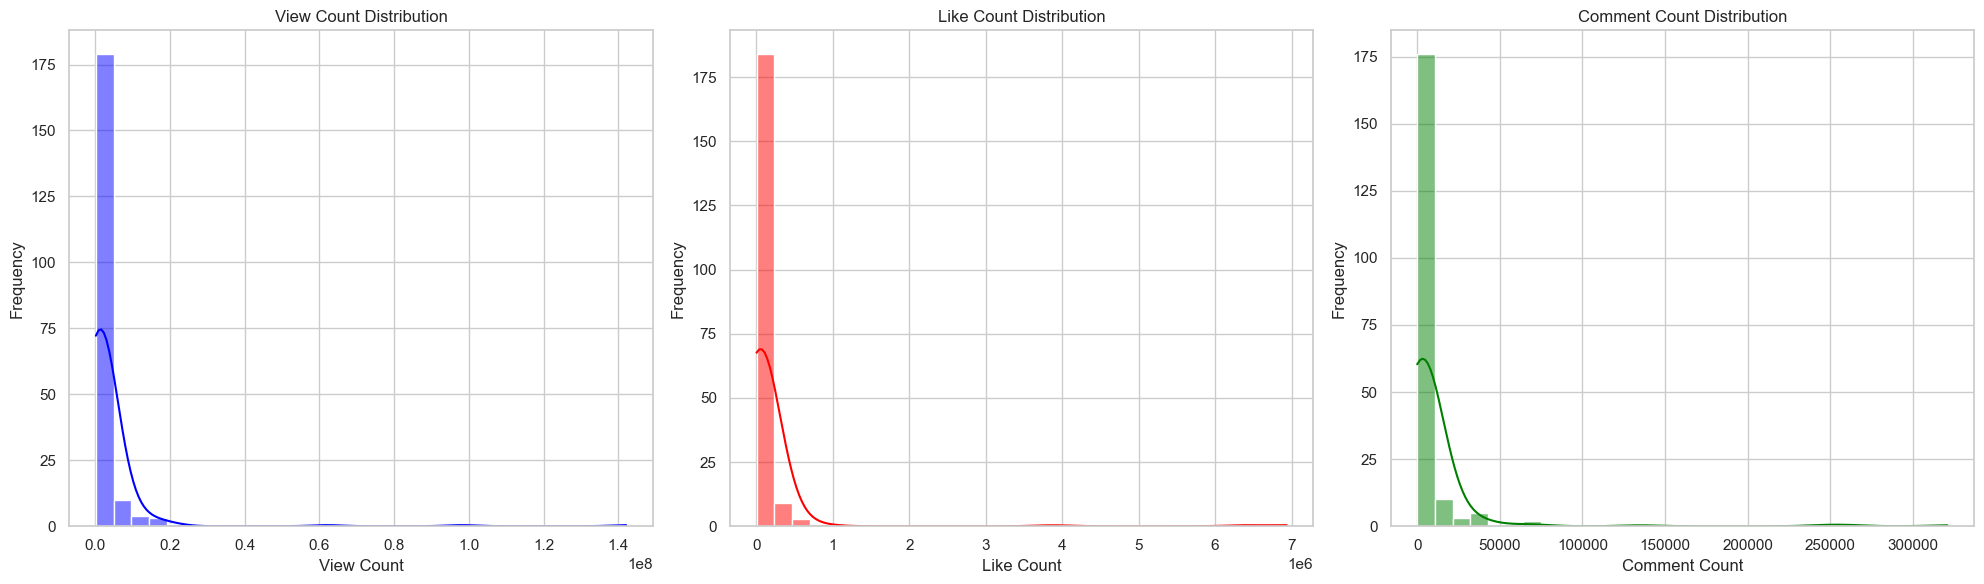

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(20,6))

# view count distribution
sns.histplot(trending_videos['view_count'], bins=30, kde=True, ax=axes[0], color='blue')
axes[0].set_title('View Count Distribution')
axes[0].set_xlabel('View Count')
axes[0].set_ylabel('Frequency')

# like count distribution
sns.histplot(trending_videos['like_count'], bins=30, kde=True, ax=axes[1], color='red')
axes[1].set_title('Like Count Distribution')
axes[1].set_xlabel('Like Count')
axes[1].set_ylabel('Frequency')

# comment count distribution
sns.histplot(trending_videos['comment_count'], bins=30, kde=True, ax=axes[2], color='green')
axes[2].set_title('Comment Count Distribution')
axes[2].set_xlabel('Comment Count')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

The histograms show that the distributions of view counts, like counts, and comment counts are right-skewed, with most videos having lower counts and a few videos having very high counts. 

Now, let’s have a look at the correlation between likes, views, and comments

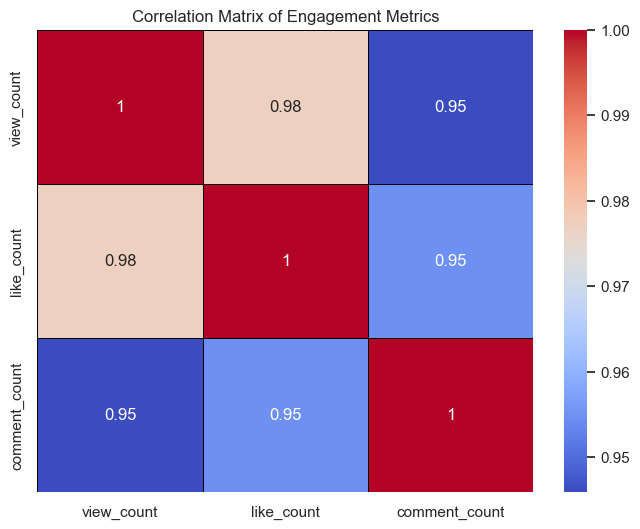

In [29]:
correlation_matrix = trending_videos[['view_count','like_count','comment_count']].corr()

plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, linecolor='black')
plt.title('Correlation Matrix of Engagement Metrics')
plt.show()

The heatmap confirms strong positive correlations between views, likes, and comments.

Let's collect the category names of the videos.

In [30]:
from googleapiclient.discovery import build

API_KEY = 'Your API Key'
youtube = build('youtube', 'v3', developerKey=API_KEY)

In [32]:
def get_category_mapping():
    request = youtube.videoCategories().list(
        part='snippet',
        regionCode='US'
    )
    response = request.execute()
    category_mapping = {}
    for item in response['items']:
        category_id = int(item['id'])
        category_name = item['snippet']['title']
        category_mapping[category_id] = category_name
    return category_mapping

In [34]:
category_mapping = get_category_mapping()
print(category_mapping)

{1: 'Film & Animation', 2: 'Autos & Vehicles', 10: 'Music', 15: 'Pets & Animals', 17: 'Sports', 18: 'Short Movies', 19: 'Travel & Events', 20: 'Gaming', 21: 'Videoblogging', 22: 'People & Blogs', 23: 'Comedy', 24: 'Entertainment', 25: 'News & Politics', 26: 'Howto & Style', 27: 'Education', 28: 'Science & Technology', 29: 'Nonprofits & Activism', 30: 'Movies', 31: 'Anime/Animation', 32: 'Action/Adventure', 33: 'Classics', 34: 'Comedy', 35: 'Documentary', 36: 'Drama', 37: 'Family', 38: 'Foreign', 39: 'Horror', 40: 'Sci-Fi/Fantasy', 41: 'Thriller', 42: 'Shorts', 43: 'Shows', 44: 'Trailers'}


Now, lets analyze the number of trending videos by category

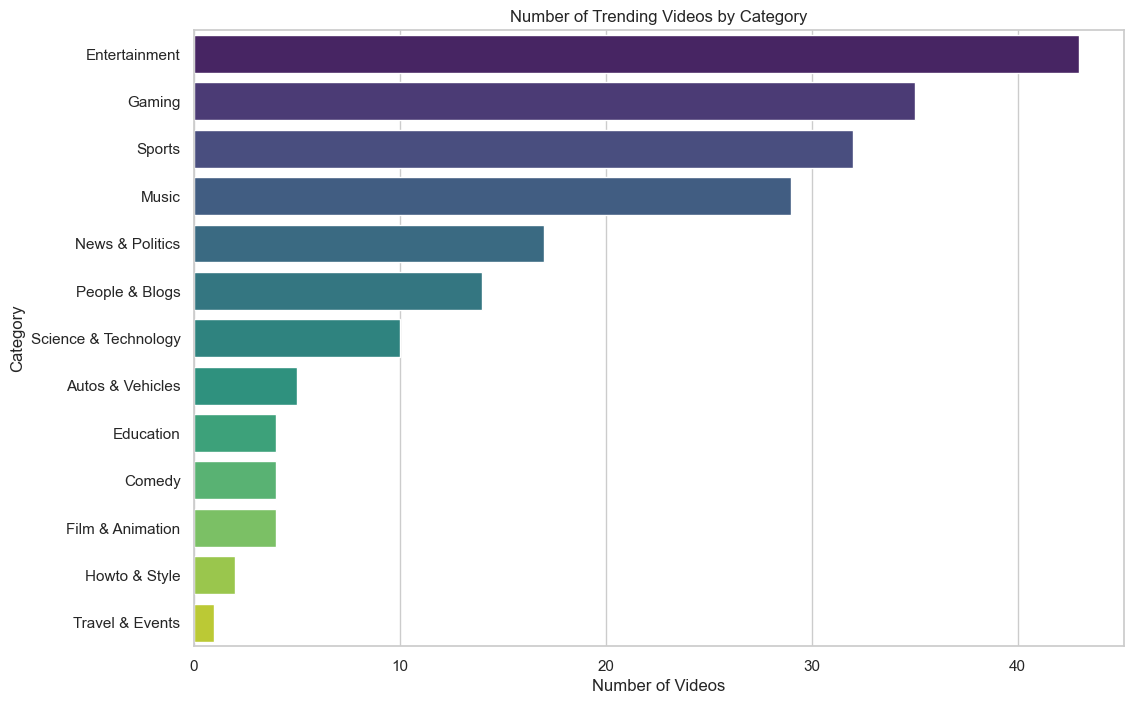

In [41]:
trending_videos['category_name'] = trending_videos['category_id'].map(category_mapping)

plt.figure(figsize=(12,8))
sns.countplot(y=trending_videos['category_name'], order=trending_videos['category_name'].value_counts().index, palette='viridis')
plt.title('Number of Trending Videos by Category')
plt.xlabel('Number of Videos')
plt.ylabel('Category')
plt.show()

The bar chart shows that the Gaming, Entertainment, Sports, and Music categories have the highest number of trending videos. 

Now, let’s have a look at the average engagement metrics by category

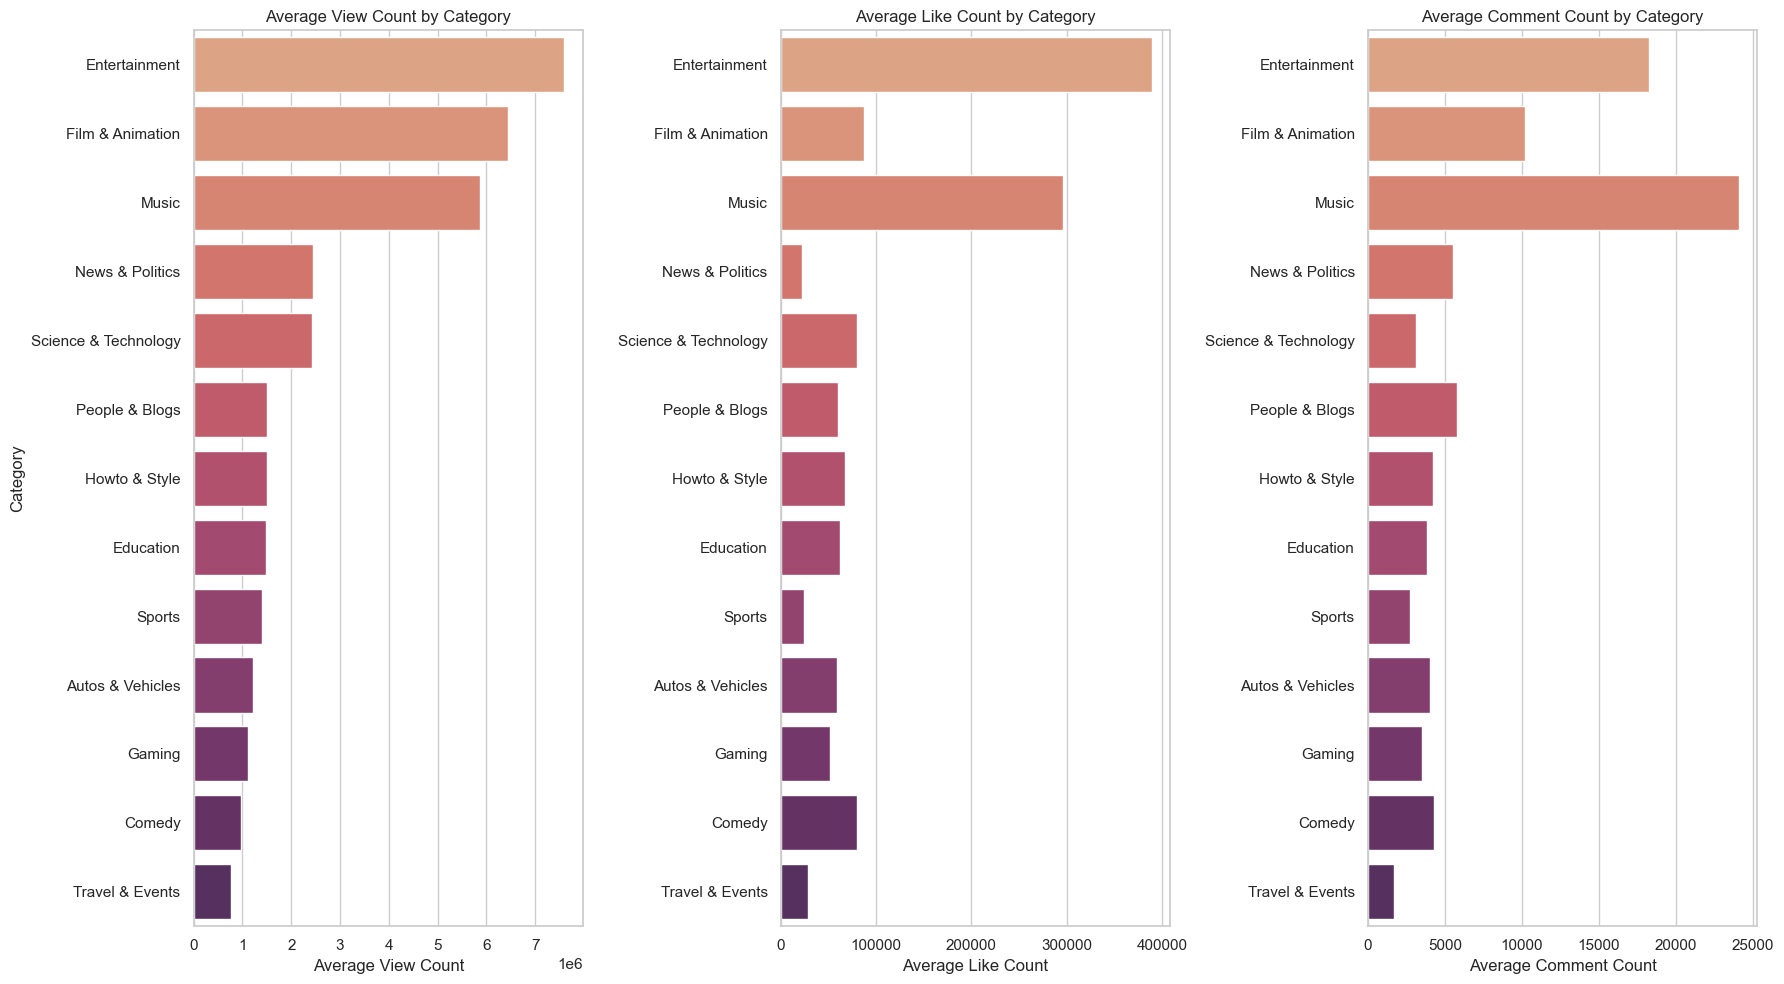

In [46]:
# average engagement metrics by category
category_engagement = trending_videos.groupby('category_name')[['view_count','like_count','comment_count']].mean().sort_values(by='view_count',ascending=False)

fig, axes = plt.subplots(1, 3, figsize=(18,10))

# view count by category
sns.barplot(y=category_engagement.index, x=category_engagement['view_count'], ax=axes[0], palette='flare')
axes[0].set_title('Average View Count by Category')
axes[0].set_xlabel('Average View Count')
axes[0].set_ylabel('Category')

# like count by category
sns.barplot(y=category_engagement.index, x=category_engagement['like_count'], ax=axes[1], palette='flare')
axes[1].set_title('Average Like Count by Category')
axes[1].set_xlabel('Average Like Count')
axes[1].set_ylabel('')

# comment count by category
sns.barplot(y=category_engagement.index, x=category_engagement['comment_count'], ax=axes[2], palette='flare')
axes[2].set_title('Average Comment Count by Category')
axes[2].set_xlabel('Average Comment Count')
axes[2].set_ylabel('')

plt.tight_layout()
plt.show()

Entertainement and Music categories have the highest average view counts, likes, and comments. Film & Animation also shows high engagement, especially in view counts.

Now, let’s analyze the content and duration of the videos. But first, we need to convert the duration from ISO 8601 format to seconds

In [47]:
import isodate

trending_videos['duration_seconds'] = trending_videos['duration'].apply(lambda x: isodate.parse_duration(x).total_seconds())

trending_videos['duration_range'] = pd.cut(trending_videos['duration_seconds'], bins=[0, 300, 600, 1200, 3600, 7200], labels=['0-5 min', '5-10 min', '10-20 min', '20-60 min', '60-120 min'])

Now, let’s analyze the content and the duration of videos

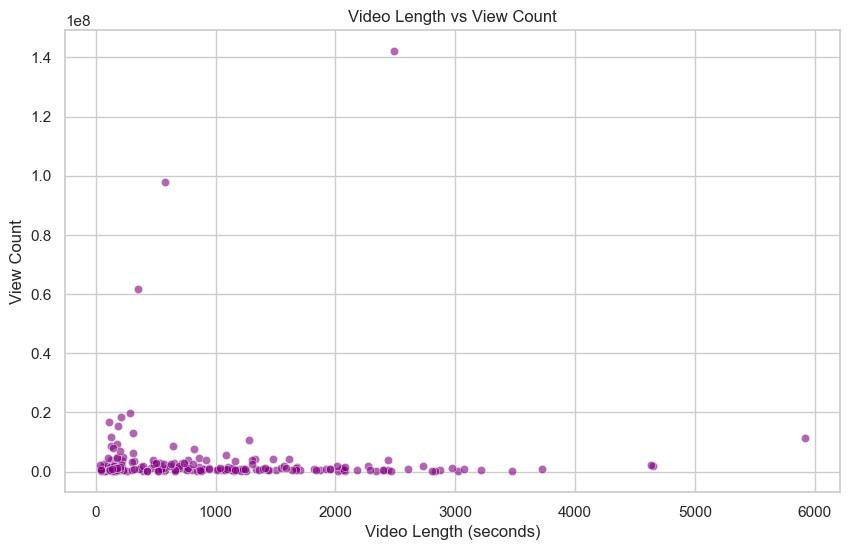

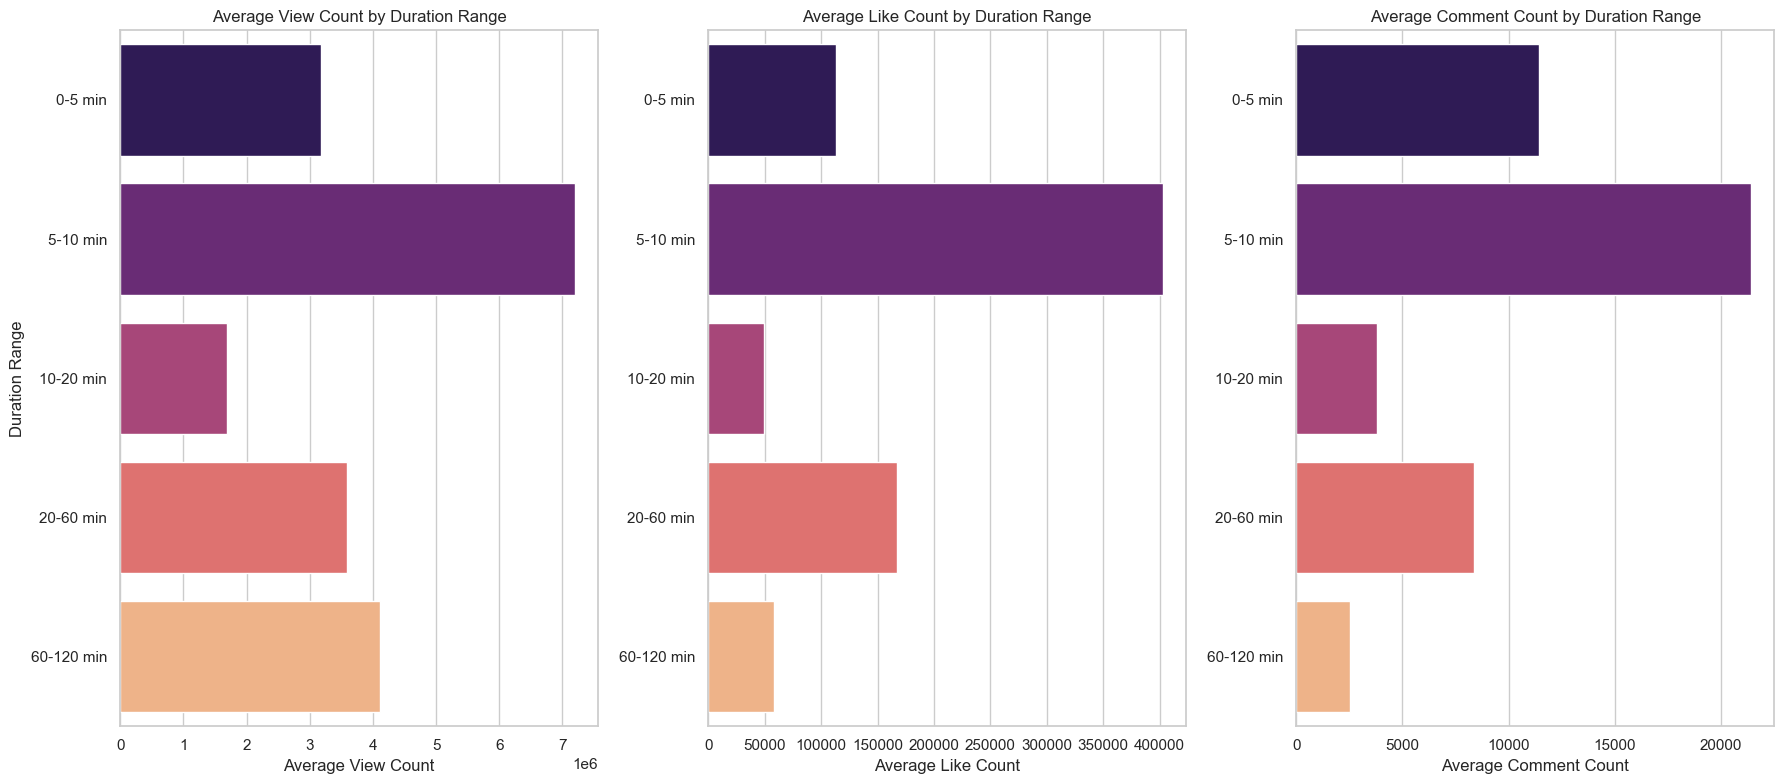

In [53]:
# video lenght vs view count
plt.figure(figsize=(10,6))
sns.scatterplot(x='duration_seconds', y='view_count', data=trending_videos, alpha=0.6, color='purple')
plt.title('Video Length vs View Count')
plt.xlabel('Video Length (seconds)')
plt.ylabel('View Count')
plt.show()

# bar chart for engagement metrics by duration range
lenght_engagement = trending_videos.groupby('duration_range')[['view_count','like_count','comment_count']].mean()

fig,axes = plt.subplots(1, 3, figsize=(18,8))

# view count by category
sns.barplot(y=lenght_engagement.index, x=lenght_engagement['view_count'], ax=axes[0], palette='magma')
axes[0].set_title('Average View Count by Duration Range')
axes[0].set_xlabel('Average View Count')
axes[0].set_ylabel('Duration Range')

# like count by category
sns.barplot(y=lenght_engagement.index, x=lenght_engagement['like_count'], ax=axes[1], palette='magma')
axes[1].set_title('Average Like Count by Duration Range')
axes[1].set_xlabel('Average Like Count')
axes[1].set_ylabel('')

# comment count by category
sns.barplot(y=lenght_engagement.index, x=lenght_engagement['comment_count'], ax=axes[2], palette='magma')
axes[2].set_title('Average Comment Count by Duration Range')
axes[2].set_xlabel('Average Comment Count')
axes[2].set_ylabel('')

plt.tight_layout()
plt.show()

We can see that videos in the 5-10 min range have the highest average view counts, likes and comments.

Now, let’s analyze the relationship between views and number of tags used in the video

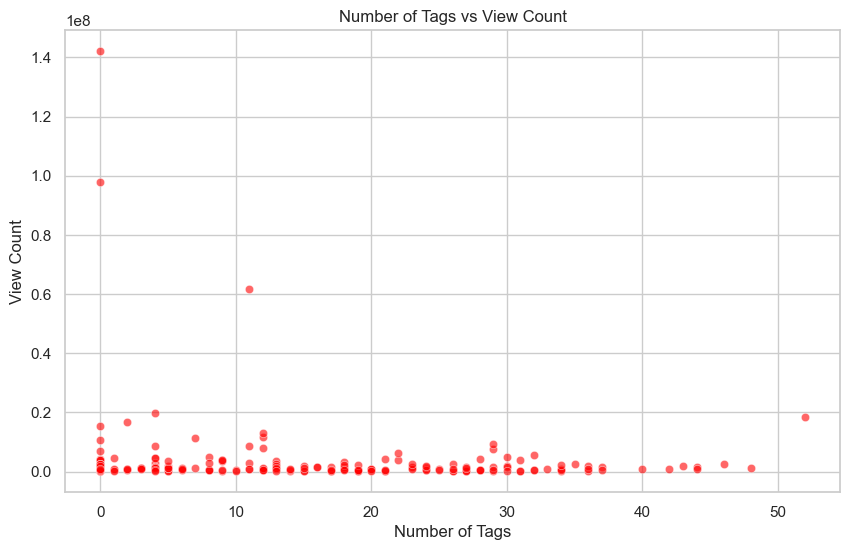

In [54]:
# calculate the number of tags for each video
trending_videos['tag_count'] = trending_videos['tags'].apply(len)

# plot for numbr of tags vs view count
plt.figure(figsize=(10,6))
sns.scatterplot(x='tag_count', y='view_count', data=trending_videos, alpha=0.6, color='red')
plt.title('Number of Tags vs View Count')
plt.xlabel('Number of Tags')
plt.ylabel('View Count')
plt.show()

The scatter plot shows a very weak relationship between the number of tags and view count, suggesting that the number of tags has minimal impact on a video’s view count.

Now, let’s see if there’s relationship between the time a video is posted and it number of views

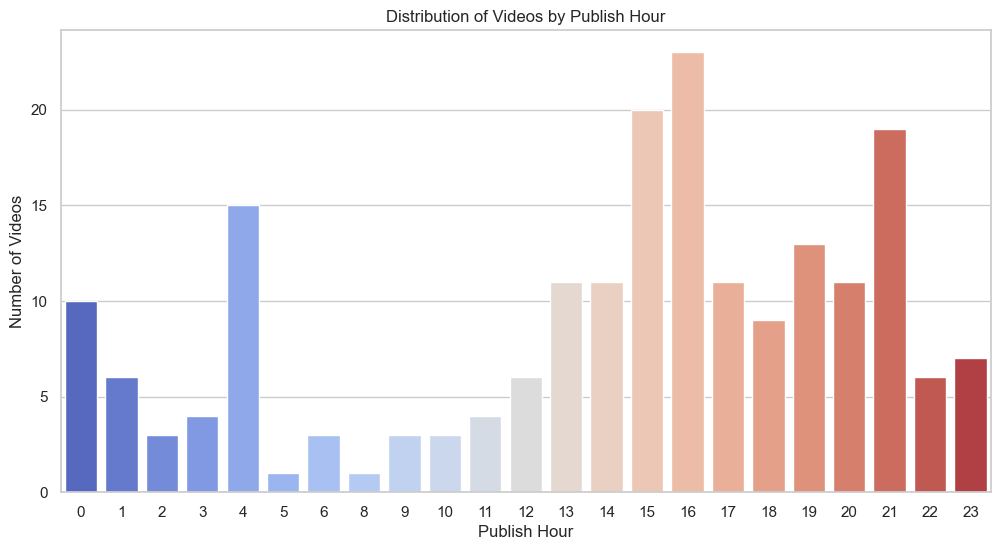

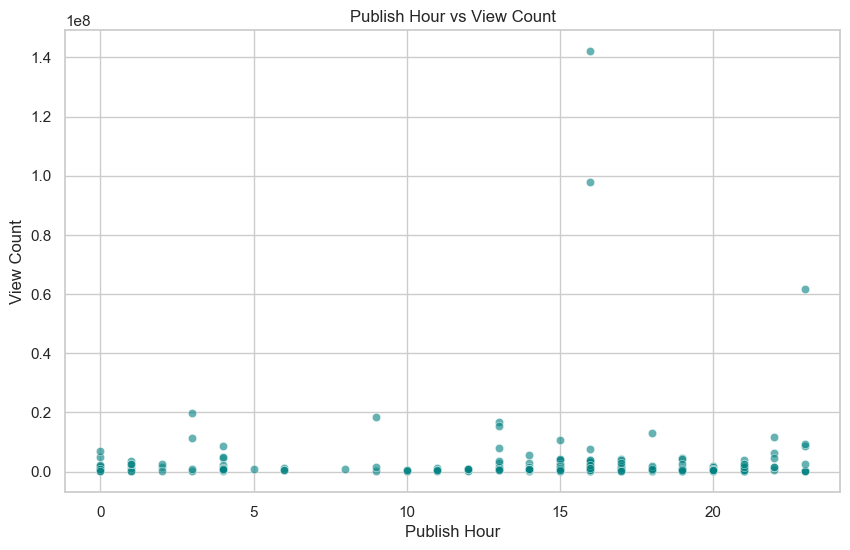

In [55]:
# extract hour of publication
trending_videos['publish_hour'] = trending_videos['published_at'].dt.hour

# bar chart for publish hour distribution
plt.figure(figsize=(12,6))
sns.countplot(x='publish_hour', data=trending_videos, palette='coolwarm')
plt.title('Distribution of Videos by Publish Hour')
plt.xlabel('Publish Hour')
plt.ylabel('Number of Videos')
plt.show()

# scatter plot for publish hour vs view count
plt.figure(figsize=(10, 6))
sns.scatterplot(x='publish_hour', y='view_count', data=trending_videos, alpha=0.6, color='teal')
plt.title('Publish Hour vs View Count')
plt.xlabel('Publish Hour')
plt.ylabel('View Count')
plt.show()

The distribution shows that most videos are published between 14:00 and 20:00, indicating this may be an optimal time for uploading videos.
There is a very weak negative relationship between publish hour and view count, suggesting that the hour of publication has minimal impact on engagement metrics.

# Conclusion


- Encourage viewers to like and comment on videos to boost engagement metrics.

- Aim to create shorter videos (between 5 and 10 mins) for higher engagement, especially for categories like Music and Entertainment.

- Schedule video uploads around peak times (14:00 - 20:00) to maximize initial views and engagement.